# Galileo and GPS constellations DOP

This Jupyter notebook simulates and compares the DOP depending on the user latitude for the Galileo and GPS constellations. Both the reference constellations (with and without spares/additional satellites) and the real constellations taken from the almanac at 2020-01-01 are used.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import Angle, EarthLocation, ITRS
import cartopy.crs as ccrs
from multiprocessing import Pool
from functools import partial

In [2]:
def era(t):
    # formula from https://en.wikipedia.org/wiki/Sidereal_time#Earth_Rotation_Angle
    # direct computation in ITRS using LAAN has been checked to yield
    # similar results to computation in GCRS and conversion to ITRS with Astropy
    tU = t - Time(2451545, format = 'jd')
    return Angle(2*np.pi*(0.7790572732640+1.00273781191135448*tU/u.day)*u.rad).wrap_at('180d')

class Constellation:
    def __init__(self, a, e, i, raan0, omega0, M0, t0, draan = 0*u.deg/u.day, domega = 0*u.deg/u.day, dM = None):
        self.a = a
        self.e = e
        self.i = i
        self.raan0 = raan0
        self.omega0 = omega0
        self.M0 = M0
        self.t0 = t0
        self.draan = draan
        self.domega = domega
        self.dM = dM
    
    def xyz(self, t):
        t = t.reshape((-1,1))
        
        # use mean anomaly rate if provided, else derive it from Keplerian orbit
        n = self.dM if self.dM is not None else np.sqrt(const.GM_earth/self.a**3) * u.rad
        tk = (t - self.t0)
        M = (self.M0 + n*tk).wrap_at('180d')
        # series expansion in e for nu
        nu = M + (self.e * np.sin(M) + self.e**2*5/4*np.sin(2*M) - self.e**3*(1/4*np.sin(M) \
                    - 13/12*np.sin(3*M)))* u.rad if self.e else M
        omega = self.omega0 + self.domega * tk
        uu = nu + omega
        r = self.a * (1 - self.e**2) / (1 + self.e*np.cos(nu)) if self.e else self.a
        x_ = r * np.cos(uu)
        y_ = r * np.sin(uu)
        raan = self.raan0 + self.draan * tk
        laan = raan - era(t)
        x = x_ * np.cos(laan) - y_ * np.cos(self.i) * np.sin(laan)
        y = x_ * np.sin(laan) + y_ * np.cos(self.i) * np.cos(laan)
        z = y_ * np.sin(self.i)
        return ITRS(x = x, y = y, z = z, obstime = t, representation_type = 'cartesian')
    
    @property
    def size(self):
        return self.M0.size

Galileo reference constellation information taken from [GSC Orbital and technical parameters](https://www.gsc-europa.eu/system-service-status/orbital-and-technical-parameters). Note that there is a typo and slots B2 and B7 are swapped. This constellation is a Walker 24/3/1 constellation.

In [3]:
# information taken from https://www.gsc-europa.eu/system-service-status/orbital-and-technical-parameters
galileo_data = """GSAT0101 	E11 	B05 	29599.8 	0.0 	56.0 	77.632 	0.0 	15.153
GSAT0102 	E12 	B06 	29599.8 	0.0 	56.0 	77.632 	0.0 	60.153
GSAT0103 	E19 	C04 	29599.8 	0.0 	56.0 	197.632 	0.0 	345.153
GSAT0104 	E20 	C05 	29599.8 	0.0 	56.0 	197.632 	0.0 	30.153
GSAT0203 	E26 	B08 	29599.8 	0.0 	56.0 	77.632 	0.0 	150.153
GSAT0204 	E22 	B03 	29599.8 	0.0 	56.0 	77.632 	0.0 	285.153
GSAT0205 	E24 	A08 	29599.8 	0.0 	56.0 	317.632 	0.0 	135.153
GSAT0206 	E30 	A05 	29599.8 	0.0 	56.0 	317.632 	0.0 	0.153
GSAT0208 	E08 	C07 	29599.8 	0.0 	56.0 	197.632 	0.0 	120.153
GSAT0209 	E09 	C02 	29599.8 	0.0 	56.0 	197.632 	0.0 	255.153
GSAT0210 	E01 	A02 	29599.8 	0.0 	56.0 	317.632 	0.0 	225.153
GSAT0211 	E02 	A06 	29599.8 	0.0 	56.0 	317.632 	0.0 	45.153
GSAT0207 	E07 	C06 	29599.8 	0.0 	56.0 	197.632 	0.0 	75.153
GSAT0212 	E03 	C08 	29599.8 	0.0 	56.0 	197.632 	0.0 	165.153
GSAT0213 	E04 	C03 	29599.8 	0.0 	56.0 	197.632 	0.0 	300.153
GSAT0214 	E05 	C01 	29599.8 	0.0 	56.0 	197.632 	0.0 	210.153
GSAT0215 	E21 	A03 	29599.8 	0.0 	56.0 	317.632 	0.0 	270.153
GSAT0216 	E25 	A07 	29599.8 	0.0 	56.0 	317.632 	0.0 	90.153
GSAT0217 	E27 	A04 	29599.8 	0.0 	56.0 	317.632 	0.0 	315.153
GSAT0218 	E31 	A01 	29599.8 	0.0 	56.0 	317.632 	0.0 	180.153
GSAT0219 	E36 	B04 	29599.8 	0.0 	56.0 	77.632 	0.0 	330.153
GSAT0220 	E13 	B01 	29599.8 	0.0 	56.0 	77.632 	0.0 	195.153
GSAT0221 	E15 	B02 	29599.8 	0.0 	56.0 	77.632 	0.0 	105.153
GSAT0222 	E33 	B07 	29599.8 	0.0 	56.0 	77.632 	0.0 	240.153"""

The positions of the 6 future spares satellites haven't been defined anywhere. We use the example given by [Teunissen etl.](https://books.google.co.uk/books?id=93goDwAAQBAJ&pg=PA249&lpg=PA249&dq=galileo+spare+slots&source=bl&ots=BCix7PHkaI&sig=ACfU3U00v2_H8sothLcUp2og3H-b2WToJw&hl=en&sa=X&ved=2ahUKEwiT46Dk8Y3nAhXIb1AKHa9BB2wQ6AEwA3oECAcQAQ#v=onepage&q=galileo%20spare%20slots&f=false) to position the spares.

In [4]:
raan = [float(l.split()[-3]) for l in galileo_data.split('\n')]
galileo_raan = Angle(np.array([raan])*u.deg)
M = [float(l.split()[-1]) for l in galileo_data.split('\n')]
galileo_M = Angle(np.array([M])*u.deg)
galileo_names = [l.split()[0] + f' ({l.split()[1]})' for l in galileo_data.split('\n')]
galileo_slots = [l.split()[2] for l in galileo_data.split('\n')]

# constellation with 6 spares. the location of the spares is indicative, as it hasn't been published
# spares between A2,A3, A6,A7, B1,B2, B5,B6, C8,C1, C4,C5
# note that B2 and B7 are swapped in galileo_data listing above
raan_spare = np.repeat([317.632, 77.632, 197.632], 2)
M_spare = [(225.153+270.153)/2, (45.153+90.153)/2, (195.153+240.153)/2, (15.153+60.153)/2,\
         (165.153+210.153)/2, (345.153-360+30.153)/2]
galileo_30_raan = Angle(np.concatenate((raan, raan_spare)).reshape((1,-1))*u.deg)
galileo_30_M = Angle(np.concatenate((M, M_spare)).reshape((1,-1))*u.deg)

galileo_a = 29599.8 * u.km
galileo_i = Angle(56.0 * u.deg)
galileo_t0 = Time('2016-01-01T00:00:00')
galileo_draan = -0.02764398 * u.deg / u.day
galileo_dM = 613.72253566 * u.deg / u.day

We load up the almanac for the first week of 2020. The almanac contains the LAAN at the start of the Galileo week (2019-12-29T00:00:00 GST = 2019-12-28T23:59:42 UTC), which must be converted to RAAN using the Earth rotation angle. The t0a of the almanac is 463200 which gives 2020-01-03T08:40:00 GST = 2020-01-03T08:39:42 UTC.

The almanac contains 22 satellites, which are all the active satellites.

In [5]:
def get_xml_field(lines, field):
    return [l.strip().lstrip(f'<{field}>').rstrip(f'</{field}>') for l in lines if l.strip().startswith(f'<{field}>')]

with open('2020-01-03.xml') as f:
    galileo_alm = f.readlines()
    
galileo_alm_prns = [int(n) for n in get_xml_field(galileo_alm, 'SVID')]
galileo_alm_laan = Angle(np.array([[float(f) for f in get_xml_field(galileo_alm, 'omega0')]])*180*u.deg)
galileo_alm_raan = galileo_alm_laan + era(Time('2019-12-28T23:59:42'))
galileo_alm_omega = Angle(np.array([[float(f) for f in get_xml_field(galileo_alm, 'w')]])*180*u.deg)
galileo_alm_M = Angle(np.array([[float(f) for f in get_xml_field(galileo_alm, 'm0')]])*180*u.deg)
galileo_alm_t0 = Time('2020-01-03T08:39:42')

We plot and compare the almanac constellation with the reference constellation. To do so, we move the almanac constellation to the timestamp of the reference constellation, updating the RAAN and mean anomalies at their nominal rates.

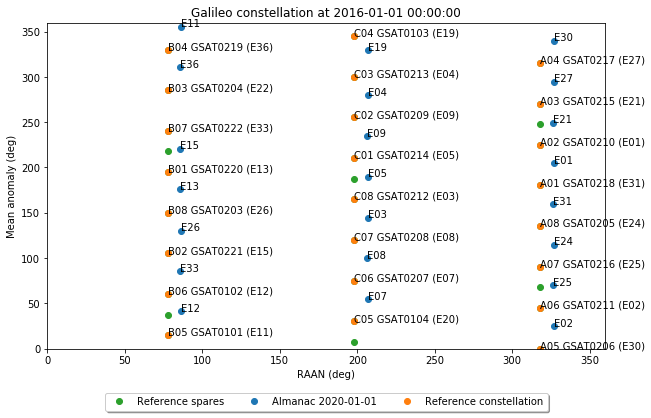

In [6]:
alpha = (galileo_alm_t0 - galileo_t0) * galileo_draan
beta = (galileo_alm_t0 - galileo_t0) * galileo_dM

plt.figure(figsize = (10,6))
plt.plot(galileo_30_raan.ravel(), galileo_30_M.ravel(), 'o', color = 'C2', label = 'Reference spares')
plt.plot((galileo_alm_raan - alpha).wrap_at('360d').ravel(),\
         (galileo_alm_omega + galileo_alm_M - beta).wrap_at('360d').ravel(), 'o', color = 'C0',\
         label = 'Almanac 2020-01-01');
plt.plot(galileo_raan.ravel(), galileo_M.ravel(), 'o', color = 'C1', label = 'Reference constellation')
for j in range(galileo_alm_raan.size):
    plt.text((galileo_alm_raan - alpha).wrap_at('360d')[0,j].deg,\
             (galileo_alm_omega + galileo_alm_M - beta).wrap_at('360d')[0,j].deg,\
             f'E{galileo_alm_prns[j]:02d}')
for j in range(galileo_raan.size):
    plt.text(galileo_raan[0,j].deg,\
             galileo_M[0,j].deg, galileo_slots[j] + ' ' + galileo_names[j])
plt.xlim((0,360))
plt.ylim((0,360))

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True, ncol=5)
plt.title(f'Galileo constellation at {galileo_t0.datetime}')
plt.xlabel('RAAN (deg)')
plt.ylabel('Mean anomaly (deg)');

In [7]:
# Galileo constellation
galileo_constellation = Constellation(a = galileo_a,\
                                      e = 0,\
                                      i = galileo_i,\
                                      raan0 = galileo_raan,\
                                      omega0 = Angle(0.0 * u.deg),\
                                      M0 = galileo_M,\
                                      t0 = galileo_t0,\
                                      draan = galileo_draan,\
                                      dM = galileo_dM)

galileo_30_constellation = Constellation(a = galileo_a,\
                                      e = 0,\
                                      i = galileo_i,\
                                      raan0 = galileo_30_raan,\
                                      omega0 = Angle(0.0 * u.deg),\
                                      M0 = galileo_30_M,\
                                      t0 = galileo_t0,\
                                      draan = galileo_draan,\
                                      dM = galileo_dM)

galileo_alm_constellation = Constellation(a = galileo_a,\
                                      e = 0,\
                                      i = galileo_i,\
                                      raan0 = galileo_alm_raan,\
                                      omega0 = galileo_alm_omega,\
                                      M0 = galileo_alm_M,\
                                      t0 = galileo_alm_t0,\
                                      draan = galileo_draan,\
                                      dM = galileo_dM)

The reference constellation for GPS is taken from the [2008 SPS performance standard](https://www.gps.gov/technical/ps/2008-SPS-performance-standard.pdf). Two constellations are defined: a 24 satellite constellation and an expandable constellation where 3 of the slots in the 24 satellite constellation can be split in two to accomodate up to 27 satellites. We consider the 24 satellite constellation and the fully split 27 satellite constellation only.

**Update:** In April 2020 the [2020 SPS performance standard](https://www.gps.gov/technical/ps/2020-SPS-performance-standard.pdf) defined a 30 satellite expanded constellation, here 6 slots of the 24 satellite base constellation are split into two. Moreover, the RAANs of the constellation have precessed 16.003 degrees. The new document also gives updated values for the semi-major axis and the drift of the RAAN. This new version of the notebook uses the constellations as defined in the 2020 SPS performance standard.

In [8]:
# values taken from https://www.gps.gov/technical/ps/2020-SPS-performance-standard.pdf
gps_raan = Angle(np.repeat([288.85, 348.85, 48.85, 108.85, 168.85, 228.85], 4).reshape((1,-1)) * u.deg)
gps_M = Angle(np.array([[239.54, 133.20, 343.09, 13.22,
                        52.37, 144.75, 281.39, 175.79,
                        83.29, 343.21, 311.08, 212.97,
                        106.64, 236.86, 6.57, 138.77,
                        168.46, 274.01, 37.48, 305.10,
                        210.30, 316.64, 76.62, 106.76]]) * u.deg)
gps_raan_exp30 = Angle(np.concatenate((
                np.repeat([288.85, 348.85, 48.85, 108.85, 168.85, 228.85], 4),
                [348.85, 108.85, 228.85, 288.85, 48.85, 168.85])).reshape((1,-1)) * u.deg)
gps_M_exp30 = Angle(np.array([[239.54, 144.40, 343.09, 13.22,
                        66.33, 144.75, 281.39, 175.79,
                        83.29, 343.21, 311.08, 220.43,
                        106.64, 254.09, 6.57, 138.77,
                        168.46, 274.01, 52.08, 305.10,
                        210.30, 331.87, 76.62, 106.76,
                        37.77, 229.39, 305.43,
                        117.96, 195.73, 23.52]]) * u.deg)

gps_a = 26559.8 * u.km
gps_i = Angle(55.0 * u.deg)
gps_t0 = Time('2016-12-31T23:59:43')
gps_draan = -0.0402 * u.deg / u.day

We load up the almanac for the first week of 2020. Note that the parameter "Right Ascen" is actually the LAAN at the start of the reference week (2019-12-29T00:00:00 GPST = 2019-12-28T23:59:42 UTC). The t0a is 503808, which gives 2020-01-03T19:56:48 GPST = 2020-01-03T19:56:30 UTC.

The almanac contains 31 satellites, including G04 (the new block III satellite), which was unhealthy at the beginning of the year but became usable after a few days, so it is also considered here.

In [9]:
with open('001.ALM') as f:
    gps_alm = f.readlines()

gps_alm_prns = [int(l.split(':')[1]) for l in gps_alm if l.startswith('ID')]
gps_alm_laan = Angle((np.array([[float(l.split(':')[1]) for l in gps_alm if l.startswith('Right Ascen')]])*u.rad).to(u.deg)).wrap_at('360d')
gps_alm_raan = gps_alm_laan + era(Time('2019-12-28T23:59:42'))
gps_alm_omega = Angle((np.array([[float(l.split(':')[1]) for l in gps_alm if l.startswith('Argument of Perigee')]])*u.rad).to(u.deg)).wrap_at('360d')
gps_alm_M = Angle((np.array([[float(l.split(':')[1]) for l in gps_alm if l.startswith('Mean Anom')]])*u.rad).to(u.deg)).wrap_at('360d')

gps_alm_t0 = Time('2020-01-03T19:56:30')

gps_alm_slots = ['D2', 'D1', 'E1', 'A6', 'E3', 'D4', 'A4', 'C3', 'F3', 'E2', 'D5', 'B4', 'F6', 'F5', 'F2', 'B1', 'C4', 'C5', 'E4', 'D3', 'E6', 'F4', 'A1', 'B2', 'B5', 'C2', 'B3', 'C1', 'A3', 'A2', 'F1']
gps_slots = [plane + str(n) for plane in 'ABCDEF' for n in range(1,5)]

We plot and compare the almanac constellation with the reference constellation. To do so, we move the almanac constellation to the timestamp of the reference constellation, updating the RAAN and mean anomalies at their nominal rates. The nominal mean anomaly rate (mean motion) is taken to be 2 revolutions per sidereal day.

**Update:** The 2020 SPS gives a slightly different orbital radius that causes a slightly different dM. This is used below to propagate the almanac constellation to the reference constellation epoch, obtain good agreement. The new. As seen below, the old orbital radius of 26559.7km made a full revolution take 5.02 seconds less than a sidereal day, while the new orbital radiuse of 26559.8km makes a full revolution take 4.77 seconds less than a sidereal day. The difference is small, but noticeable when propagated over several years.

In [10]:
gps_dM = (np.sqrt(const.GM_earth/(26559.7*u.km)**3) * u.rad).to(u.rad/u.s)
((360*u.deg/gps_dM) - 0.5*u.sday).to(u.s)

<Quantity -5.01541998 s>

In [11]:
gps_dM = (np.sqrt(const.GM_earth/gps_a**3) * u.rad).to(u.rad/u.s)
((360*u.deg/gps_dM) - 0.5*u.sday).to(u.s)

<Quantity -4.77213559 s>

In [12]:
((1/((360*u.deg/(0.5*u.sday)/u.rad)**2/const.GM_earth)).to(u.km**3))**(1/3)

<Quantity 26561.76150804 km>

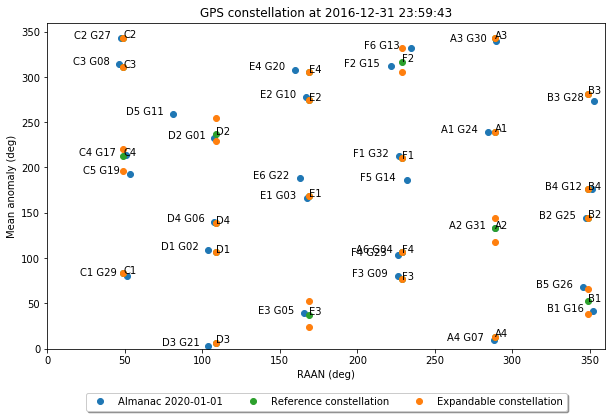

In [13]:
alpha = (gps_alm_t0 - gps_t0) * gps_draan
# This was the old beta of 2 revolutions / sday
# beta = (gps_alm_t0 - gps_t0) * 2*360*u.deg/u.sday
# This new beta is not exactly 2 revolutions per sday
beta = (gps_alm_t0 - gps_t0) * gps_dM

plt.figure(figsize = (10,6))
plt.plot((gps_alm_raan - alpha).wrap_at('360d').ravel(),\
         (gps_alm_M + gps_alm_omega - beta).wrap_at('360d').ravel(), 'o', color = 'C0', label = 'Almanac 2020-01-01')
plt.plot(gps_raan.ravel(), gps_M.ravel(), 'o', color = 'C2', label = 'Reference constellation')
plt.plot(gps_raan_exp30.ravel(), gps_M_exp30.ravel(), 'o', color = 'C1', label = 'Expandable constellation')
for j in range(gps_raan.size):
    plt.text(gps_raan[0,j].deg, gps_M[0,j].deg, gps_slots[j])
for j in range(gps_alm_raan.size):
    plt.annotate(f'{gps_alm_slots[j]} G{gps_alm_prns[j]:02d}',
                 xy = ((gps_alm_raan - alpha).wrap_at('360d')[0,j].deg,
                         (gps_alm_M + gps_alm_omega - beta).wrap_at('360d')[0,j].deg),
                 xytext = ((gps_alm_raan - alpha).wrap_at('360d')[0,j].deg - 30,
                         (gps_alm_M + gps_alm_omega - beta).wrap_at('360d')[0,j].deg))
plt.xlim((0,360))
plt.ylim((0,360))

# Put a legend below current axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True, ncol=5)
plt.title(f'GPS constellation at {gps_t0.datetime}')
plt.xlabel('RAAN (deg)')
plt.ylabel('Mean anomaly (deg)');

In [14]:
gps_constellation = Constellation(a = gps_a,\
                                  e = 0.0,\
                                  i = gps_i,\
                                  raan0 = gps_raan,\
                                  omega0 = Angle(0.0 * u.deg),\
                                  M0 = gps_M,\
                                  t0 = gps_t0,\
                                  draan = gps_draan)

gps_exp30_constellation = Constellation(a = gps_a,\
                                  e = 0.0,\
                                  i = gps_i,\
                                  raan0 = gps_raan_exp30,\
                                  omega0 = Angle(0.0 * u.deg),\
                                  M0 = gps_M_exp30,\
                                  t0 = gps_t0,\
                                  draan = gps_draan)

gps_alm_constellation = Constellation(a = 26559.7 * u.km,\
                                  e = 0.0,\
                                  i = gps_i,\
                                  raan0 = gps_alm_raan,\
                                  omega0 = gps_alm_omega,\
                                  M0 = gps_alm_M,\
                                  t0 = gps_alm_t0,\
                                  draan = gps_draan)

Below we plot the position of the reference and almanac constellations for the current time. The almanac constellations can be compared to real time status in [galmon.eu](https://galmon.eu/geo/) to validate the orbit propagation and constellation parameters.

In [15]:
def plot_constellation(constellation, names, t):
    plt.figure(figsize = (14,8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    xyz = constellation.xyz(t)
    plt.plot(xyz.earth_location.geodetic.lon, xyz.earth_location.geodetic.lat, 'o', color = 'C0')
    for j,name in enumerate(names):
        plt.text(xyz[0,j].earth_location.geodetic.lon.deg, xyz[0,j].earth_location.geodetic.lat.deg, name)
    ax.coastlines()
    ax.set_global()

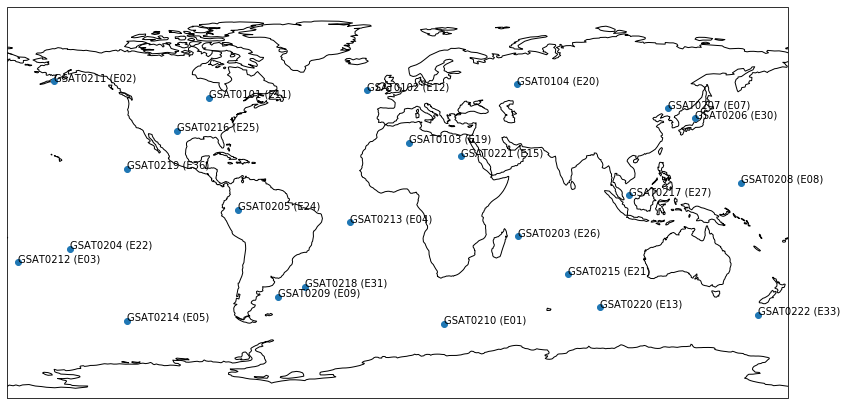

In [16]:
plot_constellation(galileo_constellation, galileo_names, Time.now())

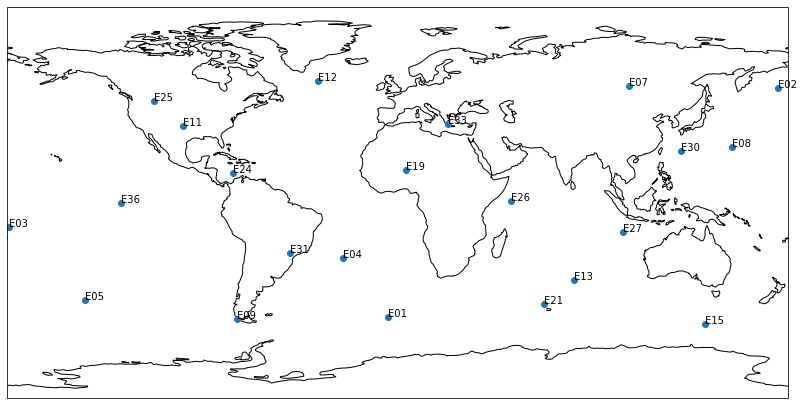

In [17]:
plot_constellation(galileo_alm_constellation, [f'E{n:02d}' for n in galileo_alm_prns], Time.now())

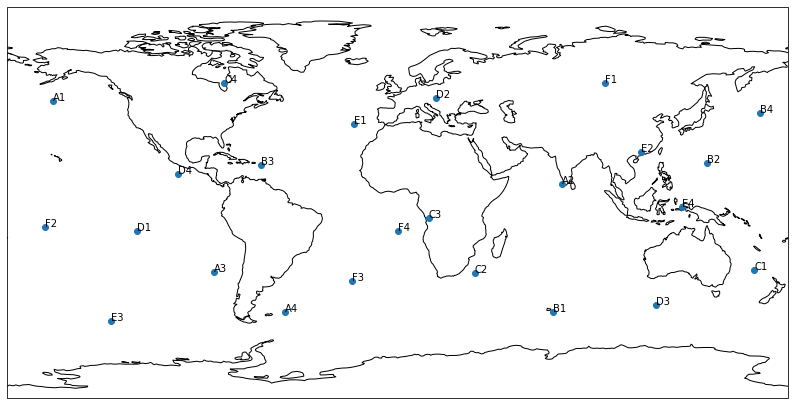

In [18]:
plot_constellation(gps_constellation, gps_slots, Time.now())

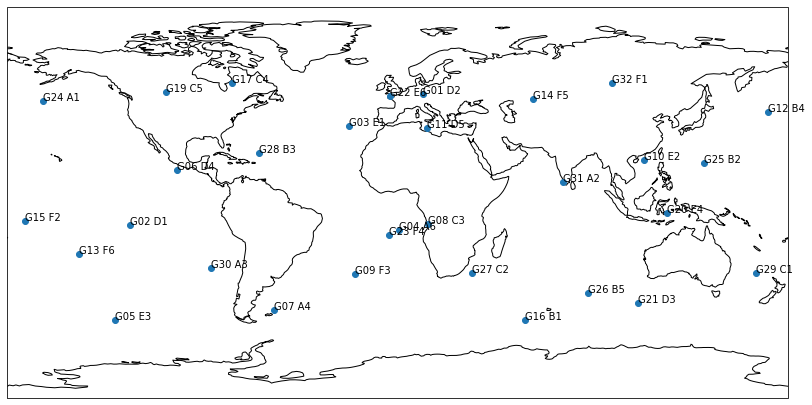

In [19]:
plot_constellation(gps_alm_constellation, [f'G{n:02d} {slot}' for n,slot in zip(gps_alm_prns, gps_alm_slots)],\
                   Time.now())

We only consider satellites above an elevation mask of 5 degrees

In [20]:
elevation_mask = 5 * u.deg

In [21]:
# This is a reference implementation, used to validate the optimized implementation given below
def compute_dops(xyz, observer):
    xyz = np.einsum('jki->ijk', xyz)
    uvw = xyz - np.array(observer.get_itrs().cartesian.xyz.to(u.km))[:,np.newaxis,np.newaxis]
    # rotation matrix taken from https://scivision.github.io/pymap3d/ecef.html uvw2enu()
    uvw2enu = np.array([[-np.sin(observer.lon), np.cos(observer.lon), 0],\
        [-np.sin(observer.lat)*np.cos(observer.lon), -np.sin(observer.lat)*np.sin(observer.lon), np.cos(observer.lat)],\
        [np.cos(observer.lat)*np.cos(observer.lon), np.cos(observer.lat)*np.sin(observer.lon), np.sin(observer.lat)]])
    enu = np.einsum('ijk,li->jkl', uvw, uvw2enu)

    ej = enu/np.sqrt(np.sum(enu**2, axis = 2))[...,np.newaxis]
    visible = ej[:,:,2] >= np.sin(elevation_mask)
    J0 = np.empty((enu.shape[0], enu.shape[1], 4))
    J0[:,:,:3] = -ej
    J0[:,:,3] = 1
    J0[~visible, :] = 0
    DOPs = np.linalg.inv(np.einsum('ijl,ijk->ilk', J0, J0))[:,np.arange(4),np.arange(4)]
    return DOPs

def alloc_J0(time_steps, nsats):
    return np.empty((time_steps, nsats, 4))

# optimized implementation using Cholesky, an external J0 array and some code rewrite
# J0 is passed to prevent realocating all the time
def compute_dops_cholesky(xyz, observer, J0):
    uvw = xyz - np.array(observer.get_itrs().cartesian.xyz.to(u.km))[np.newaxis,np.newaxis,:]
    # rotation matrix taken from https://scivision.github.io/pymap3d/ecef.html uvw2enu()
    #return None
    lon = observer.lon
    lat = observer.lat
    slon = np.sin(lon)
    slat = np.sin(lat)
    clon = np.cos(lon)
    clat = np.cos(lat)
    uvw2enu = np.array([[-slon, clon, 0],\
        [-slat*clon, -slat*slon, clat],\
        [clat*clon, clat*slon, slat]])
    enu = np.einsum('ijk,lk->ijl', uvw, -uvw2enu) # really -enu
    
    J0[:,:,:3] = enu/np.sqrt(np.einsum('ijk,ijk->ij', enu, enu))[...,np.newaxis]
    visible = J0[:,:,2] < -np.sin(elevation_mask) # note we have -ej in J0
    J0[:,:,3] = 1
    J0[~visible, :] = 0
    # Cholesky decomposition L*L = J0*J0
    L = np.linalg.cholesky(np.einsum('ijl,ijk->ilk', J0, J0))
    DOPs = np.empty((J0.shape[0],4))
    for j in range(4):
        en = np.zeros((1,4))
        en[0,j] = 1
        v = np.linalg.solve(L, en)
        DOPs[:, j] = np.einsum('ij,ij->i', v.conj(), v)
    return DOPs

The simulation time is the constellation repetition rate (10 sidereal days for Galileo, 1 sidereal day for GPS), in steps of approximately 1 minute.

In [22]:
repetition_gal = 10 * u.sday
t_start = Time('2020-01-01T00:00:00')
t_gal = t_start + np.linspace(0, repetition_gal, int(np.ceil(repetition_gal.to(u.min)/u.min)))
repetition_gps = 1 * u.sday
t_gps = t_start + np.linspace(0, repetition_gps, int(np.ceil(repetition_gps.to(u.min)/u.min)))

In [23]:
dop_types = ['GDOP', 'PDOP', 'HDOP', 'VDOP']

def dop(dops, dop_type):
    if dop_type == 'GDOP':
        return np.sqrt(np.sum(dops, axis = 1))
    if dop_type == 'PDOP':
        return np.sqrt(np.sum(dops[:,:3], axis = 1))
    if dop_type == 'HDOP':
        return np.sqrt(np.sum(dops[:, :2], axis = 1))
    if dop_type == 'VDOP':
        return np.sqrt(dops[:, 2])
    raise ValueError('Invalid DOP type')

def process_dops(dops):
    return [np.average(dop(dops, dop_type)) for dop_type in dop_types] + \
            [np.max(dop(dops, dop_type)) for dop_type in dop_types]

def dops_vs_lat(xyz, J0, lats, lon):
    return np.array([process_dops(compute_dops_cholesky(xyz, EarthLocation.from_geodetic(lon = lon, lat = lat), J0))\
                     for lat in lats])

def dops_vs_geo(constellation, t, lats, lons):
    xyz = np.empty((t.size, constellation.size, 3))
    xyz[:] = np.einsum('ijk->jki', constellation.xyz(t).cartesian.xyz.to(u.km))
    J0 = alloc_J0(t.size, constellation.size)
    with Pool() as p:
        return np.array(p.map(partial(dops_vs_lat, xyz, J0, lats), lons))

We simulate, computing DOP across the globe, with a 1º step in both latitude and longitude.

In [24]:
lats = np.arange(-90,91,1)
lons = np.arange(-180,180,1)

Uncomment to re-run the simulation. This takes 4 hours to run in my laptop.

In [25]:
%%time
#print('Simulating Galileo reference (24)...')
#galileo_dops = dops_vs_geo(galileo_constellation, t_gal, lats, lons)
#np.save('galileo_dops.npy', galileo_dops)
#print('Simulating Galileo reference + spares (30)...')
#galileo_30_dops = dops_vs_geo(galileo_30_constellation, t_gal, lats, lons)
#np.save('galileo_30_dops.npy', galileo_30_dops)
#print('Simulating Galileo almanac (22)...')
#galileo_alm_dops = dops_vs_geo(galileo_alm_constellation, t_gal, lats, lons)
#np.save('galileo_alm_dops.npy', galileo_alm_dops)
#print('Simulating GPS reference (24)...')
#gps_dops = dops_vs_geo(gps_constellation, t_gps, lats, lons)
#np.save('gps_dops.npy', gps_dops)
#print('Simulating GPS expandable (30)...')
#gps_exp30_dops = dops_vs_geo(gps_exp30_constellation, t_gps, lats, lons)
#np.save('gps_exp30_dops.npy', gps_exp30_dops)
#print('Simulating GPS almanac (31)...')
#gps_alm_dops = dops_vs_geo(gps_alm_constellation, t_gps, lats, lons)
#np.save('gps_alm_dops.npy', gps_alm_dops)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.6 µs


In [26]:
galileo_dops = np.load('galileo_dops.npy')
galileo_30_dops = np.load('galileo_30_dops.npy')
galileo_alm_dops = np.load('galileo_alm_dops.npy')
gps_dops = np.load('gps_dops.npy')
gps_exp30_dops = np.load('gps_exp30_dops.npy')
gps_alm_dops = np.load('gps_alm_dops.npy')

In [27]:
dop_list = [galileo_dops, galileo_30_dops, galileo_alm_dops, gps_dops, gps_exp30_dops, gps_alm_dops]
names = ['Galileo (24)', 'Galileo + spares (30)', 'Galileo almanac (22)', 'GPS (24)', 'GPS expanded (30)', 'GPS almanac (31)']
layout = [1,3,5,2,4,6]

In [28]:
vmins = [1.6, 1.45, 0.7, 1.2, 1.95, 1.8, 0.8, 1.6]
vmaxs = [2.5, 2.2, 1.2, 2, 7, 6, 2.5, 5.8]

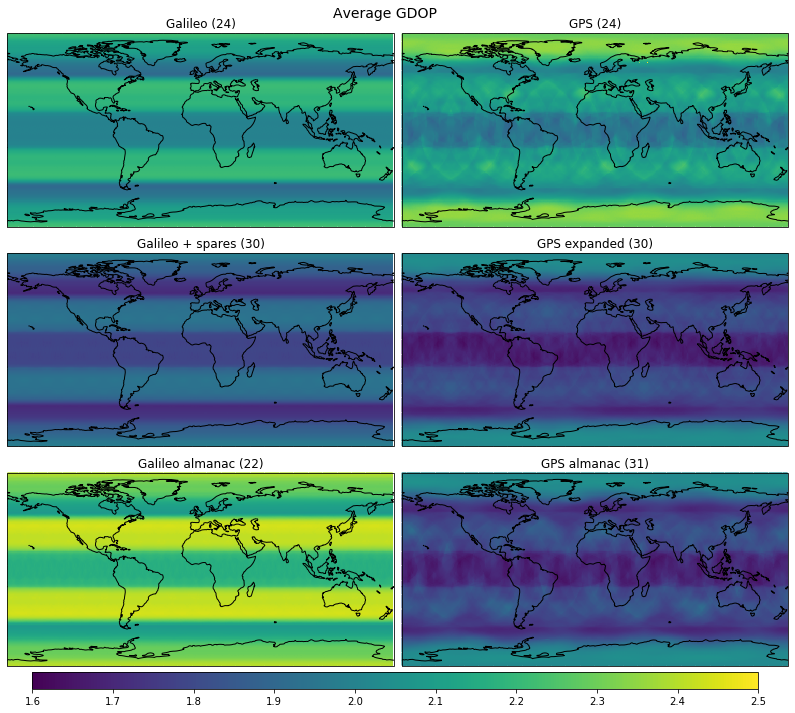

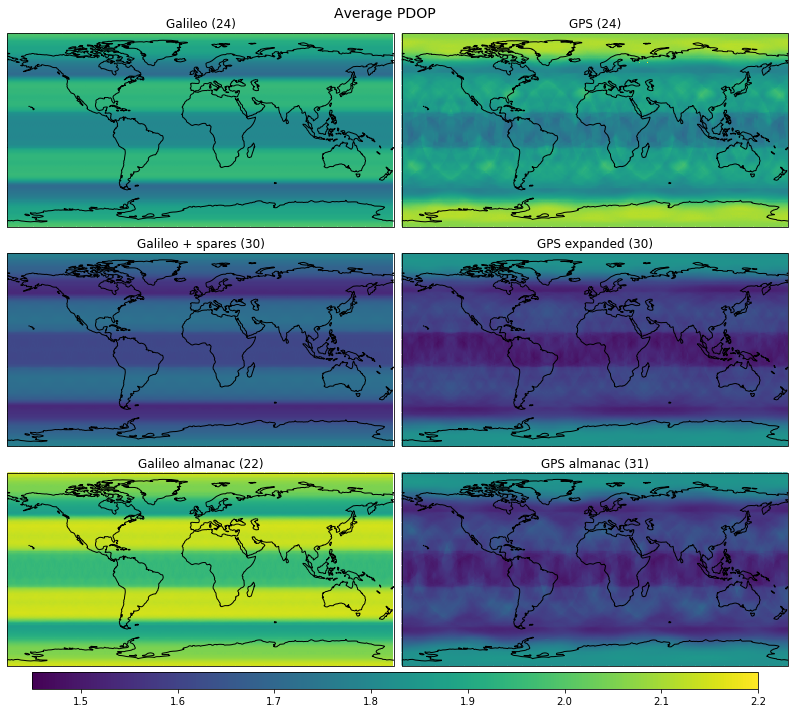

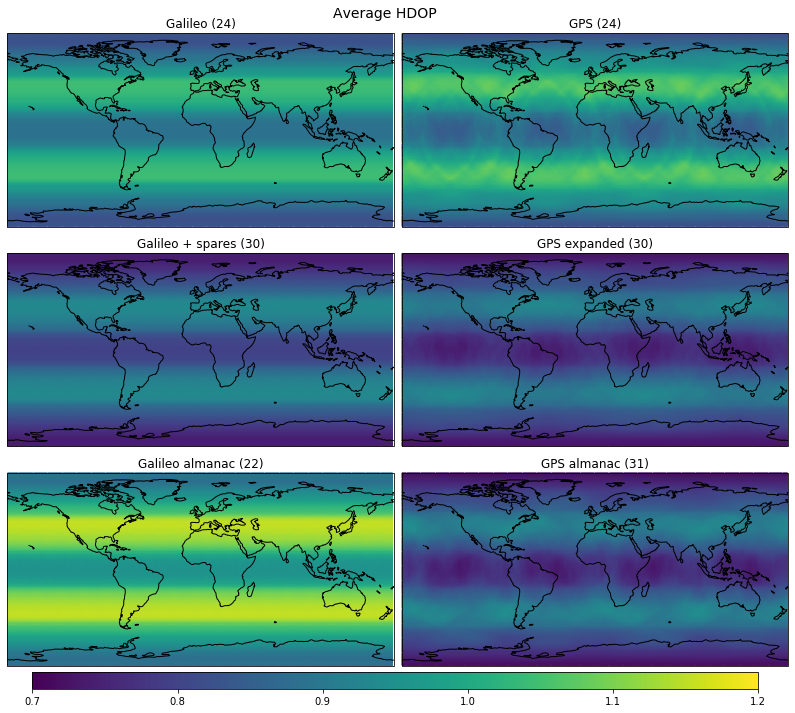

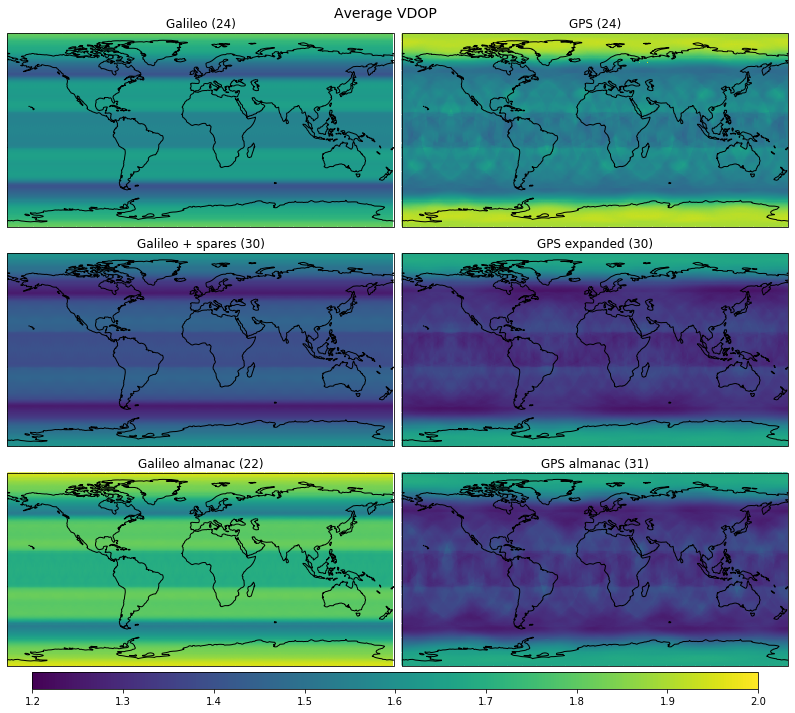

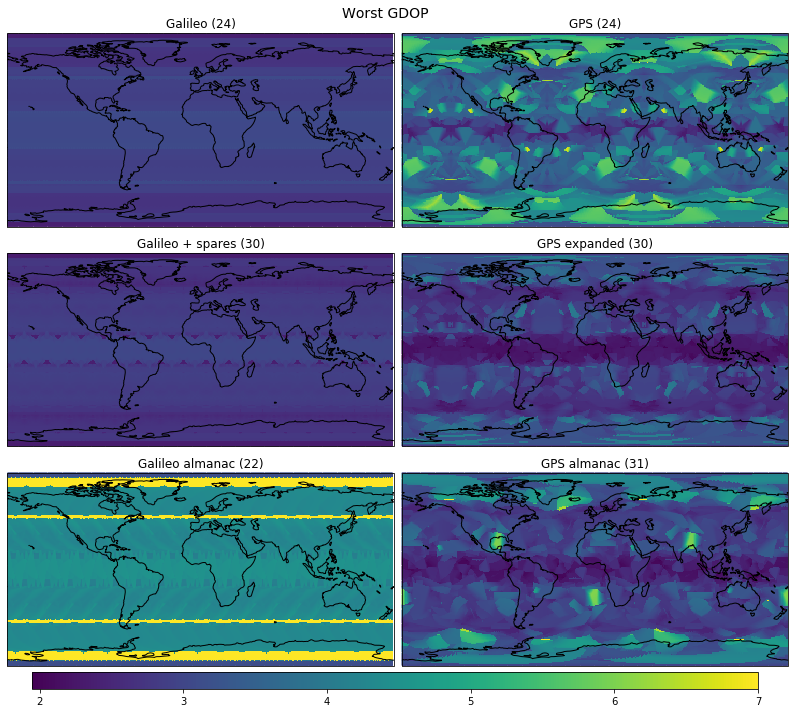

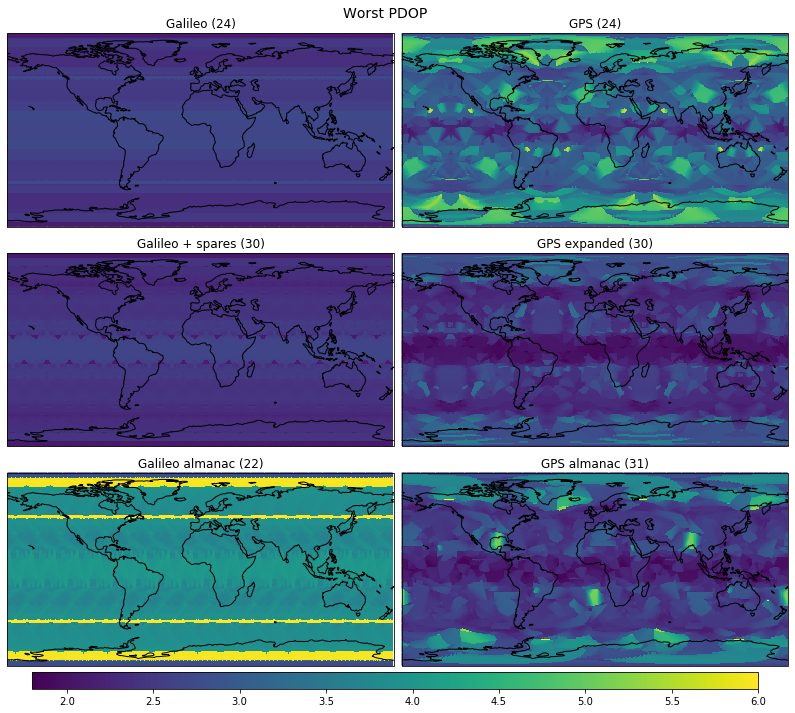

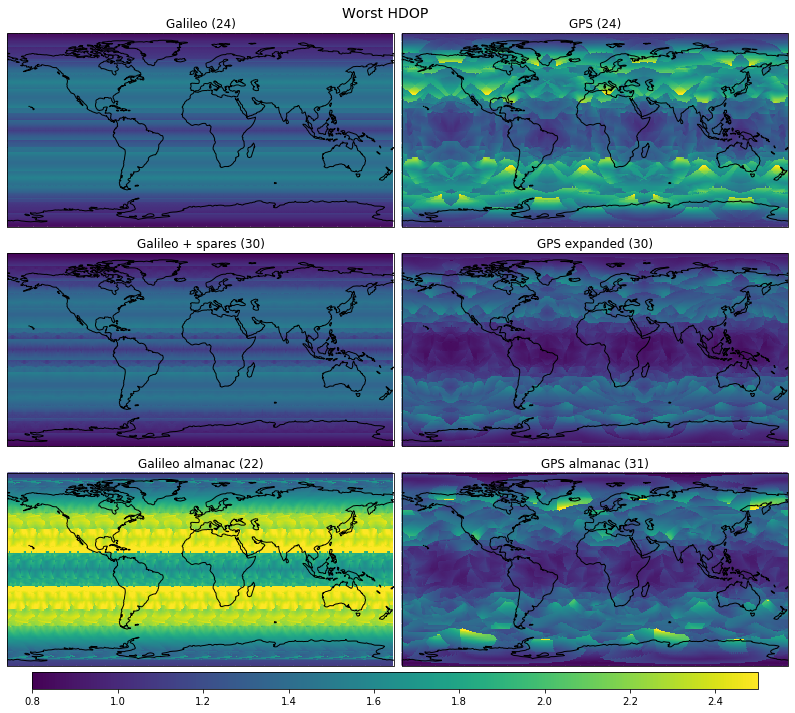

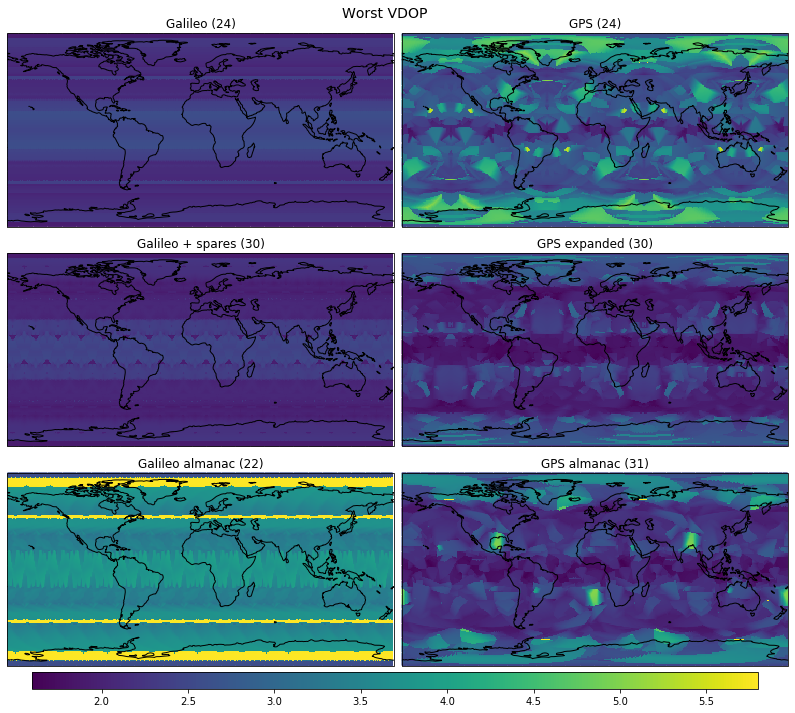

In [29]:
for i in range(8):
    fig = plt.figure(figsize = (14,12), facecolor = 'w')
    for j, constellation in enumerate(names):
        ax = plt.subplot(3, 2, layout[j], projection = ccrs.PlateCarree())
        gridlon, gridlat = np.meshgrid(lons, lats)
        img = ax.pcolormesh(gridlon, gridlat, dop_list[j][:,:,i].T, vmin = vmins[i], vmax = vmaxs[i])
        ax.coastlines()
        ax.set_title(constellation)
    cax = plt.axes([0.15, 0.11, 0.72, 0.02])
    fig.colorbar(img, cax = cax, orientation = 'horizontal', ax = ax)
    plt.subplots_adjust(wspace = 0.02, hspace = 0.03)
    plot_type = 'Average' if i < 4 else 'Worst'
    fig.suptitle(f'{plot_type} {dop_types[i%4]}', y = 0.9, fontsize = 14)

In [30]:
colors = ['C0', 'C0', 'C0', 'C1', 'C1', 'C1']
styles = [':', '--', '-', ':', '--', '-']

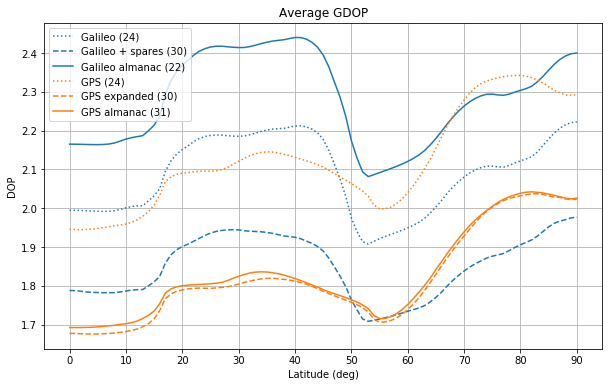

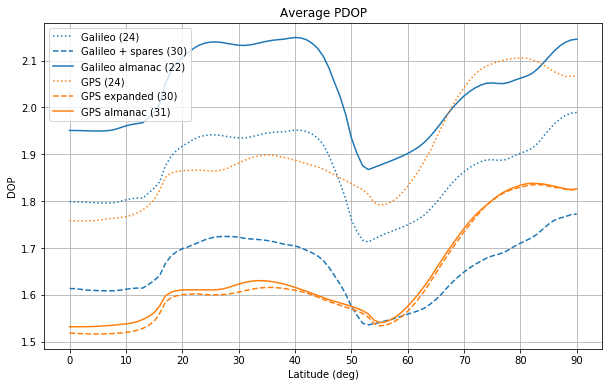

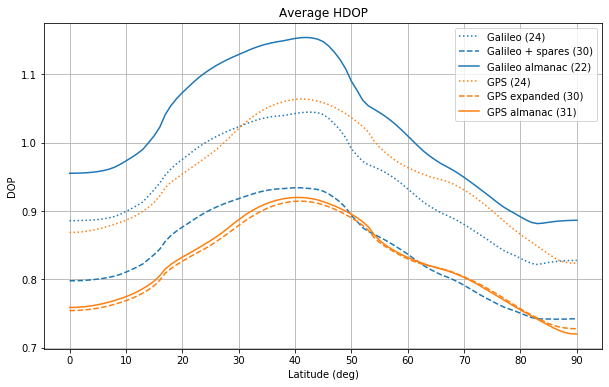

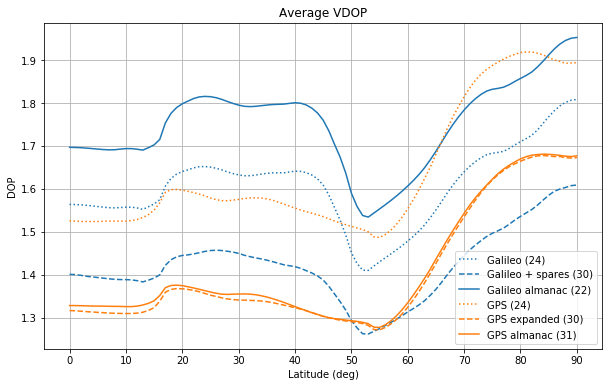

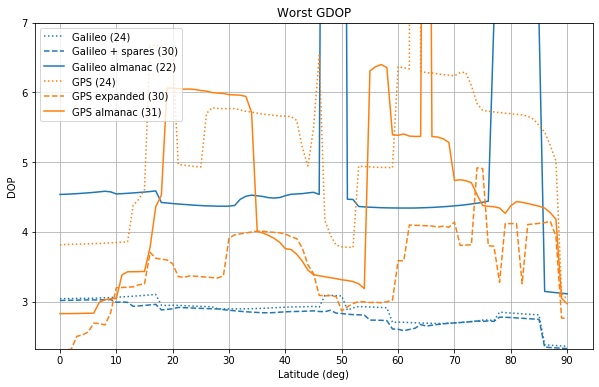

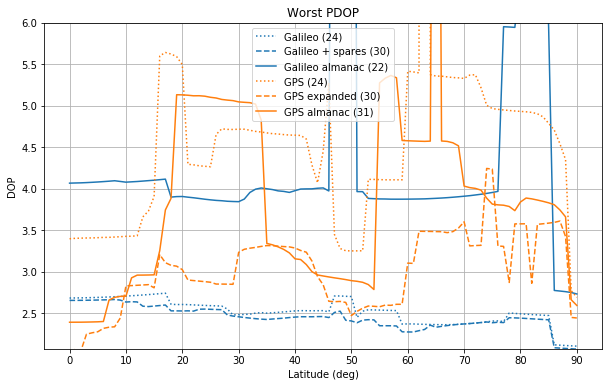

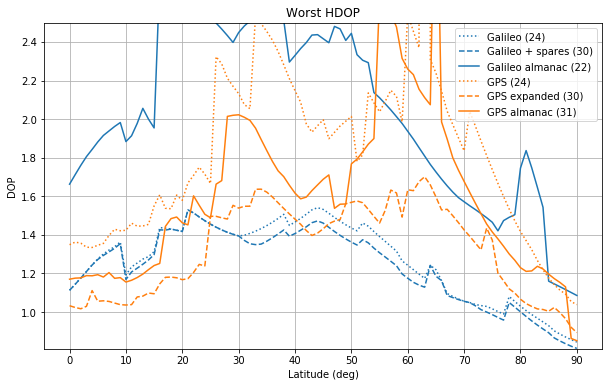

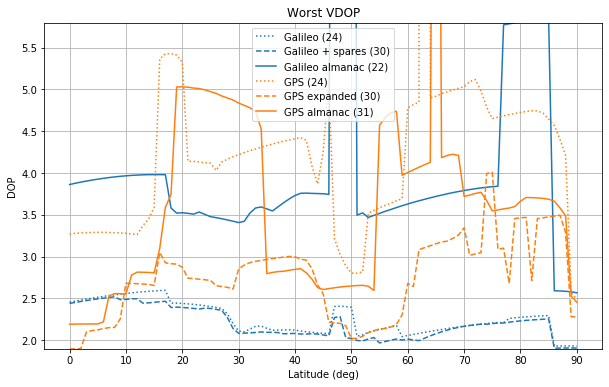

In [31]:
for i in range(8):
    plt.figure(figsize = (10,6), facecolor = 'w')
    for j, constellation in enumerate(names):
        combine = np.average if i < 4 else np.max
        plt.plot(lats[lats >= 0], combine(dop_list[j][:,lats>=0, i], axis = 0), styles[j], color = colors[j])
        plt.legend(names)
        plt.grid('both')
        plt.xticks(np.arange(0,90+10,10))
        plt.xlabel('Latitude (deg)')
        plt.ylabel('DOP')
        plot_type = 'Average' if i < 4 else 'Worst'
        plt.title(f'{plot_type} {dop_types[i%4]}')
        if i >= 4:
            plt.ylim(top = vmaxs[i])